# PyTorch Custom Datasets Video Notebook

We've used some datasets with PyTorch before.

But how do you get your own data into PyTorch?

One of the ways to do is via: custom Datasets

## Domain libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of PyTorch domain libraries for existing data loading functions and customalizable functionsm

In [1]:
import torch
from torch import nn,optim
torch.__version__

'1.9.1'

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Get data

Our dataset is a subset of the Food101 dataset.

Food101 start 101 different classes of food. (750,250)

Our dataset starts with 3 classes of fodd and only 10% of the images(75 and 25 testing)

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder

data_path = Path("data/04/01")

data_path.mkdir(parents=True,exist_ok=True)

with open(data_path / "data.zip",'wb') as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    f.write(request.content)
with zipfile.ZipFile(data_path / "data.zip", 'r') as zip_ref:
    zip_ref.extractall(data_path)

In [4]:
import os
def walk_through_dir(dir_path):
    """Walks through dir_path returning its contents."""
    for dirpath,dirnames,filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} and {len(filenames)} images in {dirpath}")

In [5]:
walk_through_dir(data_path)

There are 2 and 1 images in data/04/01
There are 3 and 0 images in data/04/01/train
There are 0 and 75 images in data/04/01/train/steak
There are 1 and 78 images in data/04/01/train/pizza
There are 0 and 3 images in data/04/01/train/pizza/.ipynb_checkpoints
There are 0 and 72 images in data/04/01/train/sushi
There are 3 and 0 images in data/04/01/test
There are 0 and 19 images in data/04/01/test/steak
There are 0 and 25 images in data/04/01/test/pizza
There are 0 and 31 images in data/04/01/test/sushi


## Visualizing an image

Let's write some code to:
1. Get all of the image paths
2. Pick a random image path using `random.choice()`
3. Get the image class name using `pathlib.Path.parent.stem`
4. Science we're working with images, let open it with PIL
5. Show and tell metadata

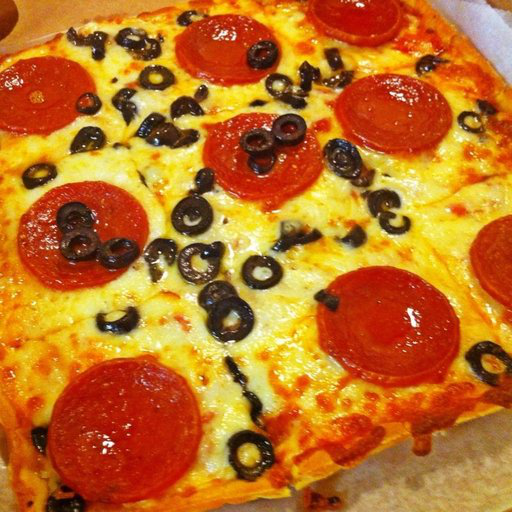

In [6]:
import random
from PIL import Image
image_path_list = list(data_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
# str(random_image_path).split("/")[-2]
image_class =  random_image_path.parent.stem
img = Image.open(random_image_path)
# 5. Print metadata
img

In [7]:
random_image_path,image_class,img.height,img.width,


(PosixPath('data/04/01/train/pizza/715169.jpg'), 'pizza', 512, 512)

In [8]:
import numpy as np
import matplotlib.pyplot as plt

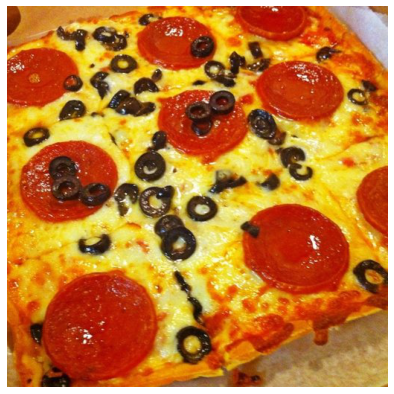

In [9]:
plt.figure(figsize=(10,7))
plt.imshow(np.asarray(img))
plt.axis(False);

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

### Transforming data with torchvision.transforms

In [11]:
data_transform = transforms.Compose([
    transforms.Resize(size=(128,128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

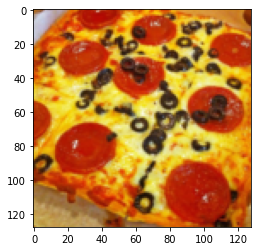

In [12]:
plt.imshow(torch.permute(data_transform(img),(1,2,0)))

In [13]:
def plot_transformed_images(image_paths,transform,n=3,seed=42):
    """
    Selects random iamges  from a pth of images and loads/transforms
    them then plots the original vs the transformed version
    """
    random_image_paths = random.sample(image_paths,k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig,ax = plt.subplots(1,2)
            ax[0].imshow(f)
            ax[0].axis(False)
            ax[1].imshow(torch.permute(transform(f),(1,2,0)))
            ax[1].axis(False)
            fig.suptitle(f"Class : {image_path.parent.stem}",fontsize=16)

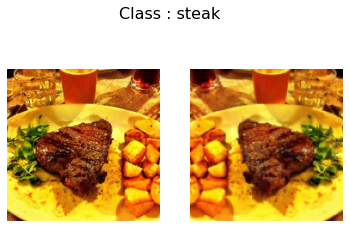

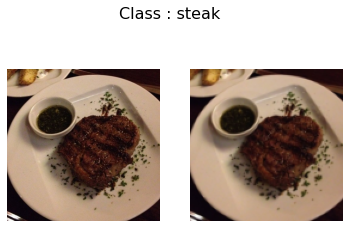

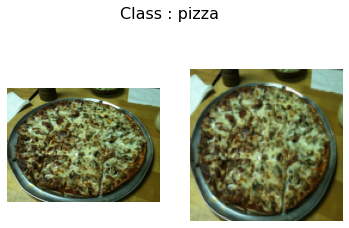

In [14]:
plot_transformed_images(image_path_list,data_transform)

## Option 1: Loading from `ImageFolder()`

We can load image clasificaation data

In [15]:
train_dir = "data/04/01/train/"
test_dir = "data/04/01/test/"

In [16]:
# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(root=train_dir,transform=data_transform)
test_data = datasets.ImageFolder(root=test_dir,transform=data_transform)

In [17]:
train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 228
     Root location: data/04/01/train/
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/04/01/test/
     StandardTransform
 Transform: Compose(
                Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [18]:
# Get class names
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [19]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [20]:
img,label = train_data[0][0],train_data[0][1]

In [21]:
img.shape,img.dtype

(torch.Size([3, 128, 128]), torch.float32)

In [22]:
label,type(label)

(0, int)

In [23]:
img_permute = img.permute(1,2,0)

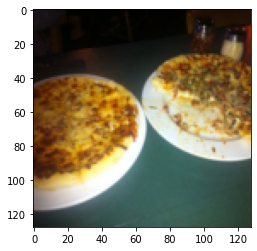

In [24]:
plt.imshow(img_permute)

### Turn loaded images into `DatLoader`'s

A `DatLoader` is going to help us turn our `DataSet`'s into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time

In [25]:
import os
os.cpu_count()

6

In [26]:
train_dataloader = DataLoader(train_data,batch_size=32,shuffle=True,num_workers=os.cpu_count())
test_dataloader = DataLoader(test_data,batch_size=32,shuffle=True,num_workers=os.cpu_count())

In [27]:
train_dataloader,test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x7f74d964f370>,
 <torch.utils.data.dataloader.DataLoader at 0x7f74d964fdc0>)

In [28]:
img,label = next(iter(train_dataloader))

In [29]:
img.shape

torch.Size([32, 3, 128, 128])

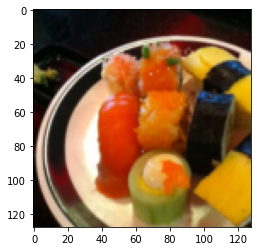

In [30]:
plt.imshow(img[0].permute(1,2,0))

## Option 2 : Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it does mean it will work...
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performence issues

In [31]:
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple,Dict,List

### Creating a helper function to get class names

We want a function to:
1. Get the class names using `os.scandir` to transverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names arent found.
3. Turn the class names into a dict and a list and return them.

In [32]:
# Setup path for target directory
target_directory = train_dir

In [33]:
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

['pizza', 'steak', 'sushi']

In [34]:
def find_classes(directory:str) -> Tuple[List[str], Dict[str,int]]:
    # Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    if not classes:
        raise FileNotFoundError(f"Couldnt finda ny classes  in {directory} ... please check file strucutre")
    class_to_idx = {class_name:i for i, class_name in enumerate(classes)}
    return classes,class_to_idx

In [35]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:
1. Subclas `torch.utils.data.Dataset`
2. Init our subclass with a target directory and a transform  
3. Create several attributes:
    * paths = paths of our images
    * transform - the transform we'd like to use
    * classes - a list of the target classes
    * class_to_idx - a dict of the target classes mapped to integar labels
4. Create a function to `load_images()`
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

In [36]:
os.listdir("data/04/01/test")

['steak', 'pizza', 'sushi']

In [37]:
# Write a custom dataset class
from torch.utils.data import Dataset
# Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    def __init__(self,targ_dir:str,transform=None):
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes,self.class_to_idx = find_classes(targ_dir)
    
    def load_image(self,index) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path)

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self,index) -> Tuple[torch.tensor,int]:
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        if self.transform:
            img = self.transform(img)
        return (img,class_idx)

In [38]:
train_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])


In [39]:
train_data_custom = ImageFolderCustom(target_directory,train_transforms)
test_data_custom = ImageFolderCustom(target_directory,test_transforms)

In [40]:
train_data_custom,test_data_custom

(<__main__.ImageFolderCustom at 0x7f7515c93910>,
 <__main__.ImageFolderCustom at 0x7f7515c93790>)

### Turn custom loaded images into `DatLoader`'s

In [41]:
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom, batch_size=32,num_workers=os.cpu_count())
test_dataloader_custom = DataLoader(dataset=test_data_custom, batch_size=32,num_workers=os.cpu_count())

## Other forms of transforms (data augmentation)

A technique of artificially increasing the training set by creating modified copies of a dataset using existing data

https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [42]:
# Let's look at trivialaugment
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    # transforms.TrivialAugmentWide(num_magnitue_bins=31),
    transforms.ToTensor()
])

In [43]:
import torchvision
torchvision.__version__

'0.10.1'

## Model 0 : TinyVGG without data augmentation

In [44]:
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])
train_ds = ImageFolderCustom("data/04/01/train/",transform =simple_transform)
test_ds = ImageFolderCustom("data/04/01/test/",transform =simple_transform)
train_dl = DataLoader(train_ds,batch_size=32,shuffle=True,num_workers=os.cpu_count())
test_dl = DataLoader(test_ds,batch_size=32,shuffle=True,num_workers=os.cpu_count())

In [63]:
class TinyVGG(nn.Module):
    def __init__(self,input_chanels,output_clzes):
        super().__init__()
        self.convblo1 = nn.Sequential(
            nn.Conv2d(input_chanels,10,kernel_size=3,stride=1,padding=1),
            nn.ReLU()
        )
        self.convblo2 = nn.Sequential(
            nn.Conv2d(10,10,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.convblo3 = nn.Sequential(
            nn.Conv2d(10,10,kernel_size=3,stride=1,padding=1),
            nn.ReLU()
        )
        self.convblo4 = nn.Sequential(
            nn.Conv2d(10,10,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.output = nn.Sequential(
            nn.Flatten(),
            nn.Linear(10*16*16,output_clzes)
        )
        
    def forward(self,X):
        y = self.convblo1(X)
        y = self.convblo2(y)
        y = self.convblo3(y)
        y = self.convblo4(y)
        # print(y.shape)
        y = self.output(y)
        return y

In [64]:
model = TinyVGG(3,len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
epochs = 100

In [65]:
def accuracy(model,loader):
    tot = 0
    no = 0
    with torch.inference_mode():
        for X,y in loader:
            preds = model(X.to(device))
            preds = torch.argmax(preds,dim=1)
            tot_iter = 0
            cor = 0
            for pred,y_iter in zip(preds,y):
                if pred == y_iter:
                    cor += 1
                tot_iter += 1
            tot += cor/tot_iter
            no += 1
    return (tot/no)*100

In [66]:
def loss_fn(model,loader,criterion):
    tot = 0
    no = 0
    with torch.inference_mode():
        for X,y in loader:
            preds = model(X.to(device))
            loss = criterion(preds.to(device),y.long().to(device))
            tot += loss.item()
            no += 1
    return tot/no

In [67]:
import wandb
from tqdm import tqdm

In [ ]:
wandb.init(project="04",name="Model:0")
for epoch in tqdm(range(epochs)):
    for X_batch,y_batch in train_dl:
        X_batch = torch.tensor(X_batch).to(device).float()
        y_batch = torch.tensor(y_batch).to(device).long()
        preds = model(X_batch)
        loss = criterion(preds,y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    wandb.log({
        "Train Loss":loss_fn(model,train_dl,criterion),
        "Test Loss":loss_fn(model,test_dl,criterion),
        "Train Accuracy":accuracy(model,train_dl),
        "Test Accuracy":accuracy(model,test_dl)
    })
wandb.finish()